## 探索数据

以下的研究报告使用了自2010-12-01至2011-12-09的英国电商订单数据：[数据源](https://www.kaggle.com/carrie1/ecommerce-data)

本篇使用了SparkSQL/API和Gamma-Gamma模型对一年内的CLV进行了建模及预测。

In [1]:
import gc
import pandas as pd
import numpy as np

In [6]:
transactions_schema = {
  'InvoiceNo':np.str,
  'StockCode':np.str,
  'Description':np.str,
  'Quantity':np.int64,
  'UnitPrice':np.float64,
  'CustomerID':np.str,
  'Country':np.str  
  }

In [7]:
transactions = pd.read_csv("./archive/data.csv", dtype=transactions_schema,
                           encoding='unicode_escape', parse_dates=['InvoiceDate'])

In [8]:
transactions['SalesAmt'] = transactions['Quantity'] * transactions['UnitPrice']

In [9]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext

# https://stackoverflow.com/questions/54458815/pyspark-serialized-task-exceeds-max-allowed-consider-increasing-spark-rpc-mess
conf = SparkConf().set('spark.rpc.message.maxSize','256').set("spark.executor.memory", "1g")
sc = SparkContext.getOrCreate(conf=conf)

spark = SparkSession \
    .builder \
    .appName("ss1") \
    .getOrCreate()

In [11]:
transactions.dropna(how='any', axis=0, inplace=True)

In [12]:
orders = spark.createDataFrame(transactions)
orders.createOrReplaceTempView('orders')

In [15]:
sqlDF = spark.sql("""
SELECT
  CustomerID,
  TO_DATE(InvoiceDate) as InvoiceDate,
  SUM(SalesAmt) as SalesAmt
FROM orders
GROUP BY CustomerID, TO_DATE(InvoiceDate)
""")
sqlDF.show()

+----------+-----------+------------------+
|CustomerID|InvoiceDate|          SalesAmt|
+----------+-----------+------------------+
|     17975| 2010-12-08|314.09999999999997|
|     14413| 2010-12-12|             122.7|
|     16955| 2010-12-14|             -25.0|
|     13769| 2010-12-14|              -1.7|
|     14560| 2010-12-23|             -9.95|
|     17675| 2011-01-05| 969.3599999999999|
|     12971| 2011-01-06|185.10000000000002|
|     17324| 2011-01-12|            575.18|
|     13246| 2011-01-17|347.03999999999996|
|     16997| 2011-01-18|             390.0|
|     13854| 2011-01-24|304.09999999999997|
|     16531| 2011-01-25|             146.1|
|     13784| 2011-02-01|155.51999999999998|
|     15570| 2011-02-10|              61.3|
|     16509| 2011-02-16|             363.7|
|     17135| 2011-02-23|            284.97|
|     15590| 2011-02-23|            -30.19|
|     15606| 2011-02-24|             305.7|
|     17243| 2011-02-27| 373.6499999999999|
|     14560| 2011-03-01|        

In [13]:
import plotly.express as px

In [24]:
fig = px.histogram(sqlDF.toPandas(), x='SalesAmt', histnorm='probability', nbins=50)
fig.update_layout(bargap=0.01, yaxis={"title": "Probability"})
fig.show()

由上图所示，销售额的区间特别大，我们也可以注意到有一些负的销售额，这些大概率是由于退货所引起的。让我们取一个包含了大部分数据的区间。

In [26]:
sqlDF = spark.sql("""
SELECT
  CustomerID,
  TO_DATE(InvoiceDate) as InvoiceDate,
  SUM(SalesAmt) as SalesAmt
FROM orders
GROUP BY CustomerID, TO_DATE(InvoiceDate)
HAVING SalesAmt BETWEEN 0 AND 2500
""")
sqlDF.show()

+----------+-----------+------------------+
|CustomerID|InvoiceDate|          SalesAmt|
+----------+-----------+------------------+
|     17975| 2010-12-08|314.09999999999997|
|     14413| 2010-12-12|             122.7|
|     17675| 2011-01-05| 969.3599999999999|
|     12971| 2011-01-06|185.10000000000002|
|     17324| 2011-01-12|            575.18|
|     13246| 2011-01-17|347.03999999999996|
|     16997| 2011-01-18|             390.0|
|     13854| 2011-01-24|304.09999999999997|
|     16531| 2011-01-25|             146.1|
|     13784| 2011-02-01|155.51999999999998|
|     15570| 2011-02-10|              61.3|
|     16509| 2011-02-16|             363.7|
|     17135| 2011-02-23|            284.97|
|     15606| 2011-02-24|             305.7|
|     17243| 2011-02-27| 373.6499999999999|
|     14560| 2011-03-01|             34.75|
|     17567| 2011-03-03|            535.38|
|     18183| 2011-03-10|             312.8|
|     17076| 2011-03-11|             182.7|
|     16156| 2011-03-15|309.0200

In [38]:
fig = px.histogram(sqlDF.toPandas(), x='SalesAmt', histnorm='probability', nbins=50)
fig.update_layout(bargap=0.01, yaxis={"title": "Probability"}, xaxis={"tickformat": "s"})
fig.update_xaxes(dtick=100)
fig.show()

In [39]:
sqlDF = spark.sql("""
SELECT
  CustomerID,
  COUNT(DISTINCT TO_DATE(InvoiceDate)) as Frequency
FROM orders
GROUP BY CustomerID
ORDER BY Frequency DESC
""")
sqlDF.show(5)

+----------+---------+
|CustomerID|Frequency|
+----------+---------+
|     14911|      146|
|     12748|      115|
|     17841|      113|
|     15311|       91|
|     14606|       89|
+----------+---------+
only showing top 5 rows



In [41]:
sqlDF = spark.sql("""
SELECT
  CustomerID,
  TO_DATE(InvoiceDate) as InvoiceDate,
  SUM(SalesAmt) as SalesAmt
FROM orders
WHERE CustomerID IN (14911, 12748, 17841)
GROUP BY CustomerID, TO_DATE(InvoiceDate)
ORDER BY CustomerID
""")
sqlDF.show()

+----------+-----------+------------------+
|CustomerID|InvoiceDate|          SalesAmt|
+----------+-----------+------------------+
|     12748| 2010-12-10|1416.9800000000007|
|     12748| 2011-11-07|500.85999999999973|
|     12748| 2011-03-21|             147.6|
|     12748| 2011-09-02|14.429999999999996|
|     12748| 2011-12-09| 94.11000000000001|
|     12748| 2011-11-04|108.99000000000002|
|     12748| 2011-06-10|              3.75|
|     12748| 2011-05-27|113.33000000000001|
|     12748| 2011-11-06|            249.64|
|     12748| 2011-06-21|            232.97|
|     12748| 2011-02-27|275.24999999999983|
|     12748| 2011-10-19|             318.3|
|     12748| 2011-05-01|               2.1|
|     12748| 2011-07-31|              1.25|
|     12748| 2011-11-15|            2151.5|
|     12748| 2011-08-05| 9.899999999999999|
|     12748| 2010-12-06|215.18999999999994|
|     12748| 2011-07-21|127.83000000000003|
|     12748| 2011-10-28|            -907.0|
|     12748| 2011-11-29| 563.429

In [42]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [53]:
list(df[df.CustomerID=='12748'].SalesAmt

0      113.33
1      563.43
2      249.64
3      215.19
4     -907.00
        ...  
110    207.94
111    306.84
112    170.63
113     12.12
114     29.70
Name: SalesAmt, Length: 115, dtype: float64

In [58]:
px.histogram(df[df.CustomerID=='14911'], x='SalesAmt', histnorm='probability', nbins=50)

In [55]:
fig = make_subplots(rows=1, cols=3)

trace0 = go.Histogram(x=df[df.CustomerID=='12748'].SalesAmt, histnorm='probability')
trace1 = go.Histogram(x=df[df.CustomerID=='17842'].SalesAmt, histnorm='probability')
trace2 = go.Histogram(x=df[df.CustomerID=='15311'].SalesAmt, histnorm='probability')

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 1, 3)
fig.show()

In [59]:
px.histogram(df[df.CustomerID=='12748'], x='SalesAmt', histnorm='probability', nbins=50)

In [60]:
px.histogram(df[df.CustomerID=='17841'], x='SalesAmt', histnorm='probability', nbins=50)

## 计算客户指标

Monetary Value: 重复购买的客户每单的平均花费

In [63]:
import lifetimes

current_date = transactions['InvoiceDate'].max()

metrics_pd = (
  lifetimes.utils.summary_data_from_transaction_data(
    transactions,
    customer_id_col='CustomerID',
    datetime_col='InvoiceDate',
    observation_period_end = current_date, 
    freq='D',
    monetary_value_col='SalesAmt'  # customer monetary value
    )
  )

metrics_pd.head(10)

,frequency,recency,T,monetary_value
CustomerID,,,,
12346,0.0,0.0,325.0,0.000000
12347,6.0,365.0,367.0,599.701667
12348,3.0,283.0,358.0,301.480000
12349,0.0,0.0,18.0,0.000000
12350,0.0,0.0,310.0,0.000000
12352,6.0,260.0,296.0,208.151667
12353,0.0,0.0,204.0,0.000000
12354,0.0,0.0,232.0,0.000000
12355,0.0,0.0,214.0,0.000000


In [81]:
metrics_sql = spark.sql("""
SELECT
    a.customerid as CustomerID,
    CAST(COUNT(DISTINCT a.transaction_date) - 1 as float) as frequency,
    CAST(DATEDIFF(MAX(a.transaction_date), a.first_date) as float) as recency,
    CAST(DATEDIFF(a.current_date, a.first_date) as float) as T,
    CASE                                              -- MONETARY VALUE CALCULATION
        WHEN COUNT(DISTINCT a.transaction_date)=1 THEN 0
        ELSE
            SUM(
                CASE 
                    WHEN a.first_date=a.transaction_date THEN 0
                    ELSE a.salesamount
                END
                ) / (COUNT(DISTINCT a.transaction_date)-1)
        END as monetary_value    
FROM (
SELECT
    x.customerid,
    z.first_date,
    x.transaction_date,
    y.current_date,
    x.salesamount                 
FROM (
    SELECT 
        customerid, 
        TO_DATE(InvoiceDate) as transaction_date, 
        SUM(SalesAmt) as salesamount
    FROM orders 
    GROUP BY customerid, TO_DATE(InvoiceDate)
    ) x
    CROSS JOIN (SELECT MAX(TO_DATE(InvoiceDate)) as current_date FROM orders) y
    JOIN (SELECT CustomerID, MIN(TO_DATE(InvoiceDate)) as first_date FROM orders GROUP BY CustomerID) z
    ON x.CustomerID=z.CustomerID
    WHERE x.CustomerID IS NOT NULL
    ) a
GROUP BY a.CustomerID, a.current_date, a.first_date
ORDER BY CustomerID
""")
metrics_sql.show()

+----------+---------+-------+-----+------------------+
|CustomerID|frequency|recency|    T|    monetary_value|
+----------+---------+-------+-----+------------------+
|     12346|      0.0|    0.0|325.0|               0.0|
|     12347|      6.0|  365.0|367.0| 599.7016666666667|
|     12348|      3.0|  283.0|358.0|301.47999999999996|
|     12349|      0.0|    0.0| 18.0|               0.0|
|     12350|      0.0|    0.0|310.0|               0.0|
|     12352|      6.0|  260.0|296.0|208.15166666666664|
|     12353|      0.0|    0.0|204.0|               0.0|
|     12354|      0.0|    0.0|232.0|               0.0|
|     12355|      0.0|    0.0|214.0|               0.0|
|     12356|      2.0|  303.0|325.0|           269.905|
|     12357|      0.0|    0.0| 33.0|               0.0|
|     12358|      1.0|  149.0|150.0|             683.2|
|     12359|      5.0|  324.0|331.0|          1139.606|
|     12360|      2.0|  148.0|200.0|            789.24|
|     12361|      0.0|    0.0|287.0|            

In [68]:
from pyspark.sql.functions import to_date, datediff, max, min, countDistinct, count, sum, when
from pyspark.sql.types import *

# valid customer orders
x = (
    orders
      .where(orders.CustomerID.isNotNull())
      .withColumn('transaction_date', to_date(orders.InvoiceDate))
      .groupBy(orders.CustomerID, 'transaction_date')
      .agg(sum(orders.SalesAmt).alias('salesamount'))   # SALES AMOUNT
    )

# calculate last date in dataset
y = (
  orders
    .groupBy()
    .agg(max(to_date(orders.InvoiceDate)).alias('current_date'))
  )

# calculate first transaction date by customer
z = (
  orders
    .groupBy(orders.CustomerID)
    .agg(min(to_date(orders.InvoiceDate)).alias('first_date'))
  )

# combine customer history with date info 
a = (x
    .crossJoin(y)
    .join(z, x.CustomerID==z.CustomerID, how='inner')
    .select(
      x.CustomerID.alias('customerid'), 
      z.first_date, 
      x.transaction_date,
      x.salesamount,               # SALES AMOUNT
      y.current_date
      )
    )

# calculate relevant metrics by customer
metrics_api = (a
    .groupBy(a.customerid, a.current_date, a.first_date)
    .agg(
     (countDistinct(a.transaction_date)-1).cast(FloatType()).alias('frequency'),
     datediff(max(a.transaction_date), a.first_date).cast(FloatType()).alias('recency'),
     datediff(a.current_date, a.first_date).cast(FloatType()).alias('T'),
     when(countDistinct(a.transaction_date)==1,0)                           # MONETARY VALUE
       .otherwise(
         sum(
           when(a.first_date==a.transaction_date,0)
             .otherwise(a.salesamount)
           )/(countDistinct(a.transaction_date)-1)
         ).alias('monetary_value')
       )
    .select('customerid','frequency','recency','T','monetary_value')
    .orderBy('customerid')
    )
metrics_api.show()

+----------+---------+-------+-----+------------------+
|customerid|frequency|recency|    T|    monetary_value|
+----------+---------+-------+-----+------------------+
|     12346|      0.0|    0.0|325.0|               0.0|
|     12347|      6.0|  365.0|367.0| 599.7016666666667|
|     12348|      3.0|  283.0|358.0|301.47999999999996|
|     12349|      0.0|    0.0| 18.0|               0.0|
|     12350|      0.0|    0.0|310.0|               0.0|
|     12352|      6.0|  260.0|296.0|208.15166666666664|
|     12353|      0.0|    0.0|204.0|               0.0|
|     12354|      0.0|    0.0|232.0|               0.0|
|     12355|      0.0|    0.0|214.0|               0.0|
|     12356|      2.0|  303.0|325.0|           269.905|
|     12357|      0.0|    0.0| 33.0|               0.0|
|     12358|      1.0|  149.0|150.0|             683.2|
|     12359|      5.0|  324.0|331.0|          1139.606|
|     12360|      2.0|  148.0|200.0|            789.24|
|     12361|      0.0|    0.0|287.0|            

In [69]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [70]:
display_side_by_side([metrics_pd.describe(), metrics_sql.toPandas().describe(),
                      metrics_api.toPandas().describe()],
                     ['metrics_pd', 'metrics_sql', 'metrics_api'])

,frequency,recency,T,monetary_value
count,4372.000000,4372.000000,4372.000000,4372.000000
mean,3.413541,133.723010,225.304209,213.254316
std,6.674343,133.000474,118.384168,372.810217
min,0.000000,0.000000,0.000000,-3528.340000
25%,0.000000,0.000000,115.000000,0.000000
50%,1.000000,98.000000,253.000000,148.955000
75%,4.000000,256.000000,331.000000,304.942500
max,145.000000,373.000000,373.000000,8866.081538
,frequency,recency,T,monetary_value
count,4372.000000,4372.000000,4372.000000,4372.000000


In [73]:
from datetime import timedelta

# set the last transaction date as the end point for this historical dataset
current_date = transactions['InvoiceDate'].max()

# define end of calibration period
holdout_days = 90
calibration_end_date = current_date - timedelta(days = holdout_days)

# calculate the required customer metrics
metrics_cal_pd = (
  lifetimes.utils.calibration_and_holdout_data(
    transactions,
    customer_id_col='CustomerID',
    datetime_col='InvoiceDate',
    observation_period_end = current_date,
    calibration_period_end=calibration_end_date,
    freq='D',
    monetary_value_col='SalesAmt'  # use sales amount to determine monetary value
    )
  )

# display first few rows
metrics_cal_pd.head(10)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12346,0.0,0.0,235.0,0.0000,0.0,0.000000,<90 * Days>
12347,4.0,238.0,277.0,519.7675,2.0,26.192069,<90 * Days>
12348,2.0,110.0,268.0,297.2200,1.0,103.333333,<90 * Days>
12350,0.0,0.0,220.0,0.0000,0.0,0.000000,<90 * Days>
12352,3.0,34.0,206.0,101.5600,3.0,20.090000,<90 * Days>
12353,0.0,0.0,114.0,0.0000,0.0,0.000000,<90 * Days>
12354,0.0,0.0,142.0,0.0000,0.0,0.000000,<90 * Days>
12355,0.0,0.0,124.0,0.0000,0.0,0.000000,<90 * Days>
12356,1.0,80.0,235.0,481.4600,1.0,29.175000,<90 * Days>


In [77]:
metrics_cal_sql = spark.sql("""
WITH customer_history
  AS (
    SELECT  -- nesting req'ed b/c can't SELECT DISTINCT on widget parameter
      m.*,
      90 AS duration_holdout
    FROM (
      SELECT
        x.customerid,
        z.first_date,
        x.transaction_date,
        y.current_date,
        x.salesamount
      FROM (                                            -- CUSTOMER DAILY SUMMARY
        SELECT 
          customerid, 
          TO_DATE(invoicedate) as transaction_date, 
          SUM(SalesAmt) as salesamount
        FROM orders 
        GROUP BY customerid, TO_DATE(invoicedate)
        ) x
      CROSS JOIN (SELECT MAX(TO_DATE(invoicedate)) as current_date FROM orders) y                                -- current date (according to dataset)
      INNER JOIN (SELECT customerid, MIN(TO_DATE(invoicedate)) as first_date FROM orders GROUP BY customerid) z  -- first order per customer
        ON x.customerid=z.customerid
      WHERE x.customerid is not null
      ) m
  )
SELECT
    a.customerid as CustomerID,
    a.frequency as frequency_cal,
    a.recency as recency_cal,
    a.T as T_cal,
    COALESCE(a.monetary_value,0.0) as monetary_value_cal,
    COALESCE(b.frequency_holdout, 0.0) as frequency_holdout,
    COALESCE(b.monetary_value_holdout, 0.0) as monetary_value_holdout,
    a.duration_holdout
FROM ( -- CALIBRATION PERIOD CALCULATIONS
    SELECT
        p.customerid,
        CAST(p.duration_holdout as float) as duration_holdout,
        CAST(DATEDIFF(MAX(p.transaction_date), p.first_date) as float) as recency,
        CAST(COUNT(DISTINCT p.transaction_date) - 1 as float) as frequency,
        CAST(DATEDIFF(DATE_SUB(p.current_date, p.duration_holdout), p.first_date) as float) as T,
        CASE                                              -- MONETARY VALUE CALCULATION
          WHEN COUNT(DISTINCT p.transaction_date)=1 THEN 0    -- 0 if only one order
          ELSE
            SUM(
              CASE WHEN p.first_date=p.transaction_date THEN 0  -- daily average of all but first order
              ELSE p.salesamount
              END
              ) / (COUNT(DISTINCT p.transaction_date)-1)
          END as monetary_value    
    FROM customer_history p
    WHERE p.transaction_date < DATE_SUB(p.current_date, p.duration_holdout)  -- LIMIT THIS QUERY TO DATA IN THE CALIBRATION PERIOD
    GROUP BY p.customerid, p.duration_holdout, p.current_date, p.first_date
  ) a
LEFT JOIN ( -- HOLDOUT PERIOD CALCULATIONS
  SELECT
    p.customerid,
    CAST(COUNT(DISTINCT p.transaction_date) as float) as frequency_holdout,
    AVG(p.salesamount) as monetary_value_holdout      -- MONETARY VALUE CALCULATION
  FROM customer_history p
  WHERE 
    p.transaction_date >= DATE_SUB(p.current_date, p.duration_holdout) AND  -- LIMIT THIS QUERY TO DATA IN THE HOLDOUT PERIOD
    p.transaction_date <= p.current_date
  GROUP BY p.customerid
  ) b
  ON a.customerid=b.customerid
ORDER BY CustomerID
""")
metrics_cal_sql.show()

+----------+-------------+-----------+-----+------------------+-----------------+----------------------+----------------+
|CustomerID|frequency_cal|recency_cal|T_cal|monetary_value_cal|frequency_holdout|monetary_value_holdout|duration_holdout|
+----------+-------------+-----------+-----+------------------+-----------------+----------------------+----------------+
|     12346|          0.0|        0.0|235.0|               0.0|              0.0|                   0.0|            90.0|
|     12347|          4.0|      238.0|277.0| 519.7674999999999|              2.0|                759.57|            90.0|
|     12348|          2.0|      110.0|268.0|297.21999999999997|              1.0|                 310.0|            90.0|
|     12350|          0.0|        0.0|220.0|               0.0|              0.0|                   0.0|            90.0|
|     12352|          3.0|       34.0|206.0|101.55999999999999|              3.0|    314.74333333333334|            90.0|
|     12353|          0.

In [86]:
# from pyspark.sql.functions import avg, date_sub, coalesce, lit, expr

# # valid customer orders
# x = (
#   orders
#     .where(orders.CustomerID.isNotNull())
#     .withColumn('transaction_at', to_date(orders.InvoiceDate))
#     .groupBy(orders.CustomerID, 'transaction_at')
#     .agg(sum(orders.SalesAmount).alias('salesamount'))
#   )

# # calculate last date in dataset
# y = (
#   orders
#     .groupBy()
#     .agg(max(to_date(orders.InvoiceDate)).alias('current_dt'))
#   )

# # calculate first transaction date by customer
# z = (
#   orders
#     .groupBy(orders.CustomerID)
#     .agg(min(to_date(orders.InvoiceDate)).alias('first_at'))
#   )

# # combine customer history with date info (CUSTOMER HISTORY)
# p = (x
#     .crossJoin(y)
#     .join(z, x.CustomerID==z.CustomerID, how='inner')
#     .withColumn('duration_holdout', lit(int(dbutils.widgets.get('holdout days'))))
#     .select(
#       x.CustomerID.alias('customerid'),
#       z.first_at, 
#       x.transaction_at, 
#       y.current_dt, 
#       x.salesamount,
#       'duration_holdout'
#       )
#      .distinct()
#     )

# # calculate relevant metrics by customer
# # note: date_sub requires a single integer value unless employed within an expr() call
# a = (p
#        .where(p.transaction_at < expr('date_sub(current_dt, duration_holdout)')) 
#        .groupBy(p.customerid, p.current_dt, p.duration_holdout, p.first_at)
#        .agg(
#          (countDistinct(p.transaction_at)-1).cast(FloatType()).alias('frequency_cal'),
#          datediff( max(p.transaction_at), p.first_at).cast(FloatType()).alias('recency_cal'),
#          datediff( expr('date_sub(current_dt, duration_holdout)'), p.first_at).cast(FloatType()).alias('T_cal'),
#          when(countDistinct(p.transaction_at)==1,0)
#            .otherwise(
#              sum(
#                when(p.first_at==p.transaction_at,0)
#                  .otherwise(p.salesamount)
#                )/(countDistinct(p.transaction_at)-1)
#              ).alias('monetary_value_cal')
#        )
#     )

# b = (p
#       .where((p.transaction_at >= expr('date_sub(current_dt, duration_holdout)')) & (p.transaction_at <= p.current_dt) )
#       .groupBy(p.customerid)
#       .agg(
#         countDistinct(p.transaction_at).cast(FloatType()).alias('frequency_holdout'),
#         avg(p.salesamount).alias('monetary_value_holdout')
#         )
#    )

# metrics_cal_api = (
#                  a
#                  .join(b, a.customerid==b.customerid, how='left')
#                  .select(
#                    a.customerid.alias('CustomerID'),
#                    a.frequency_cal,
#                    a.recency_cal,
#                    a.T_cal,
#                    a.monetary_value_cal,
#                    coalesce(b.frequency_holdout, lit(0.0)).alias('frequency_holdout'),
#                    coalesce(b.monetary_value_holdout, lit(0.0)).alias('monetary_value_holdout'),
#                    a.duration_holdout
#                    )
#                  .orderBy('CustomerID')
#               )

In [94]:
metrics_cal_sql_alt = spark.sql("""
WITH CustomerHistory 
  AS (
    SELECT
      m.*,
      90 as duration_holdout
    FROM (
      SELECT
        x.customerid,
        z.first_date,
        x.transaction_date,
        y.current_date,
        x.salesamount
      FROM (                                            -- CUSTOMER DAILY SUMMARY
        SELECT 
          customerid, 
          TO_DATE(invoicedate) as transaction_date, 
          SUM(SalesAmt) as salesamount 
        FROM orders 
        GROUP BY customerid, TO_DATE(invoicedate)
        ) x
      CROSS JOIN (SELECT MAX(TO_DATE(invoicedate)) as current_date FROM orders) y                                -- current date (according to dataset)
      INNER JOIN (SELECT customerid, MIN(TO_DATE(invoicedate)) as first_date FROM orders GROUP BY customerid) z  -- first order per customer
        ON x.customerid=z.customerid
      WHERE x.customerid is not null
      ) m
  )
SELECT
    a.customerid as CustomerID,
    a.frequency as frequency_cal,
    a.recency as recency_cal,
    a.T as T_cal,
    COALESCE(a.monetary_value,0.0) as monetary_value_cal,
    COALESCE(b.frequency_holdout, 0.0) as frequency_holdout,
    COALESCE(b.monetary_value_holdout, 0.0) as monetary_value_holdout,
    a.duration_holdout
FROM ( -- CALIBRATION PERIOD CALCULATIONS
    SELECT
        p.customerid,
        CAST(p.duration_holdout as float) as duration_holdout,
        CAST(DATEDIFF(MAX(p.transaction_date), p.first_date) as float) as recency,
        CAST(COUNT(DISTINCT p.transaction_date) - 1 as float) as frequency,
        CAST(DATEDIFF(DATE_SUB(p.current_date, p.duration_holdout), p.first_date) as float) as T,
        CASE                                              -- MONETARY VALUE CALCULATION
          WHEN COUNT(DISTINCT p.transaction_date)=1 THEN 0    -- 0 if only one order
          ELSE
            SUM(
              CASE WHEN p.first_date=p.transaction_date THEN 0  -- daily average of all but first order
              ELSE p.salesamount
              END
              ) / (COUNT(DISTINCT p.transaction_date)-1)
          END as monetary_value    
    FROM CustomerHistory p
    WHERE p.transaction_date < DATE_SUB(p.current_date, p.duration_holdout)  -- LIMIT THIS QUERY TO DATA IN THE CALIBRATION PERIOD
    GROUP BY p.customerid, p.duration_holdout, p.current_date, p.first_date
  ) a
LEFT OUTER JOIN ( -- HOLDOUT PERIOD CALCULATIONS
  SELECT
    p.customerid,
    CAST(COUNT(DISTINCT TO_DATE(p.invoicedate)) as float) as frequency_holdout,
    AVG(p.SalesAmt) as monetary_value_holdout      -- MONETARY VALUE CALCULATION
  FROM orders p
  CROSS JOIN (SELECT MAX(TO_DATE(invoicedate)) as current_date FROM orders) q                                -- current date (according to dataset)
  INNER JOIN (SELECT customerid, MIN(TO_DATE(invoicedate)) as first_at FROM orders GROUP BY customerid) r  -- first order per customer
    ON p.customerid=r.customerid
  WHERE 
    p.customerid is not null AND
    TO_DATE(p.invoicedate) >= DATE_SUB(q.current_date, 90) AND  -- LIMIT THIS QUERY TO DATA IN THE HOLDOUT PERIOD
    TO_DATE(p.invoicedate) <= q.current_date
  GROUP BY p.customerid
  ) b
  ON a.customerid=b.customerid
ORDER BY CustomerID
""")
metrics_cal_sql_alt.show()

+----------+-------------+-----------+-----+------------------+-----------------+----------------------+----------------+
|CustomerID|frequency_cal|recency_cal|T_cal|monetary_value_cal|frequency_holdout|monetary_value_holdout|duration_holdout|
+----------+-------------+-----------+-----+------------------+-----------------+----------------------+----------------+
|     12346|          0.0|        0.0|235.0|               0.0|              0.0|                   0.0|            90.0|
|     12347|          4.0|      238.0|277.0| 519.7674999999999|              2.0|    26.192068965517244|            90.0|
|     12348|          2.0|      110.0|268.0|297.21999999999997|              1.0|    103.33333333333333|            90.0|
|     12350|          0.0|        0.0|220.0|               0.0|              0.0|                   0.0|            90.0|
|     12352|          3.0|       34.0|206.0|101.55999999999999|              3.0|                 20.09|            90.0|
|     12353|          0.

In [96]:
# remove customers with no repeats (complete dataset)
filtered = metrics_api.where(metrics_api.frequency > 0)
# remove customers with no repeats in calibration period
filtered_cal = metrics_cal_sql.where(metrics_cal_sql.frequency_cal > 0)

# exclude dates with negative totals 
filtered = filtered.where(filtered.monetary_value > 0)
filtered_cal = filtered_cal.where(filtered_cal.monetary_value_cal > 0)

## 验证频率和客户价值的独立性

In [98]:
filtered.corr('frequency', 'monetary_value')

0.17498384279151702

有一定相关性，但不是特别明显。

## 训练花费模型

关于模型的介绍：
1. [GammaGamma](https://zhuanlan.zhihu.com/p/135195797)

模型参考文献：[The Gamma-Gamma Model of Monetary Value](https://link.zhihu.com/?target=http%3A//www.brucehardie.com/notes/025/gamma_gamma.pdf)

In [104]:
from hyperopt import hp, fmin, tpe, rand, SparkTrials, STATUS_OK, space_eval

from lifetimes.fitters.gamma_gamma_fitter import GammaGammaFitter

# define search space
search_space = hp.uniform('l2', 0.0, 1.0)

# evaluation function
def score_model(actuals, predicted, metric='mse'):
    # make sure metric name is lower case
    metric = metric.lower()

    # Mean Squared Error and Root Mean Squared Error
    if metric=='mse' or metric=='rmse':
        val = np.sum(np.square(actuals-predicted))/actuals.shape[0]
        if metric=='rmse':
            val = np.sqrt(val)

    # Mean Absolute Error
    elif metric=='mae':
        np.sum(np.abs(actuals-predicted))/actuals.shape[0]

    else:
        val = None

    return val

# define function for model training and evaluation
def evaluate_model(param):
  
    # accesss replicated input_pd dataframe
#     data = inputs.value
    data = input_pd

    # retrieve incoming parameters
    l2_reg = param

    # instantiate and configure the model
    model = GammaGammaFitter(penalizer_coef=l2_reg)

    # fit the model
    model.fit(data['frequency_cal'], data['monetary_value_cal'])

    # evaluate the model
    monetary_actual = data['monetary_value_holdout']
    monetary_predicted = model.conditional_expected_average_profit(data['frequency_holdout'], data['monetary_value_holdout'])
    mse = score_model(monetary_actual, monetary_predicted, 'mse')

    # return score and status
    return {'loss': mse, 'status': STATUS_OK}

In [105]:
# configure hyperopt settings to distribute to all executors on workers
spark_trials = SparkTrials(parallelism=2)

# select optimization algorithm
algo = tpe.suggest

# replicate input_pd dataframe to workers in Spark cluster
input_pd = filtered_cal.where(filtered_cal.monetary_value_cal > 0).toPandas()
# inputs = sc.broadcast(input_pd)

# perform hyperparameter tuning (logging iterations to mlflow)
argmin = fmin(
  fn=evaluate_model,
  space=search_space,
  algo=algo,
  max_evals=100,
  trials=spark_trials
  )

# release the broadcast dataset
# inputs.unpersist()

100%|██████████| 100/100 [02:36<00:00,  1.47s/trial, best loss: 2798.0236439798027]


INFO:hyperopt-spark:Total Trials: 100: 100 succeeded, 0 failed, 0 cancelled.


In [106]:
# print optimum hyperparameter settings
print(space_eval(search_space, argmin))

0.0031430062666279353


In [107]:
# get hyperparameter setting
l2_reg = space_eval(search_space, argmin)

# instantiate and configure model
spend_model = GammaGammaFitter(penalizer_coef=l2_reg)

# fit the model
spend_model.fit(input_pd['frequency_cal'], input_pd['monetary_value_cal'])

<lifetimes.GammaGammaFitter: fitted with 1965 subjects, p: 4.82, q: 0.49, v: 6.77>

## 评估花费模型

In [108]:
monetary_actual = input_pd['monetary_value_holdout']
monetary_predicted = spend_model.conditional_expected_average_profit(input_pd['frequency_holdout'], input_pd['monetary_value_holdout'])
mse = score_model(monetary_actual, monetary_predicted, 'mse')

print("GammaGamma Model's MSE: {0}".format(mse))

GammaGamma Model's MSE: 2797.426764297627


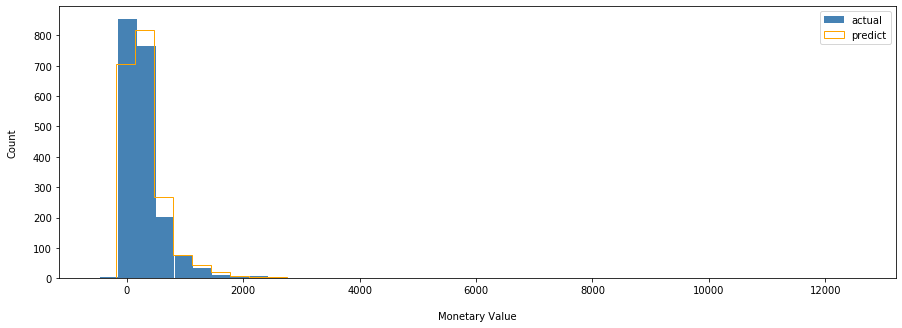

In [127]:
import matplotlib.pyplot as plt

# define histogram bin count
bins = 40

# plot size
plt.figure(figsize=(15, 5))

# histogram plot values and presentation
plt.hist(monetary_actual, bins, label='actual', histtype='bar', color='STEELBLUE', rwidth=0.99)
plt.hist(monetary_predicted, bins, label='predict', histtype='step', color='ORANGE',  rwidth=0.99)

# place legend on chart
plt.legend(loc='upper right')
plt.xlabel('\nMonetary Value')
plt.ylabel('Count\n')
plt.show()

## 计算CLV(Customer Lifetime Value)

In [111]:
from lifetimes.fitters.beta_geo_fitter import BetaGeoFitter

lifetime_input_pd = filtered_cal.toPandas() # pull data into pandas from Spark dataframe

# instantiate & configure the model (provided settings from previous hyperparam tuning exercise)
lifetimes_model = BetaGeoFitter(penalizer_coef=0.9995179967263891)

# train the model
lifetimes_model.fit(lifetime_input_pd['frequency_cal'], lifetime_input_pd['recency_cal'], lifetime_input_pd['T_cal'])

# score the model
frequency_holdout_actual = lifetime_input_pd['frequency_holdout']
frequency_holdout_predicted = lifetimes_model.predict(lifetime_input_pd['duration_holdout'], lifetime_input_pd['frequency_cal'], lifetime_input_pd['recency_cal'], lifetime_input_pd['T_cal'])
mse = score_model(frequency_holdout_actual, frequency_holdout_predicted, 'mse')

print("BG/NBD Model's MSE: {0}".format(mse))

BG/NBD Model's MSE: 3.7152590718367677


In [112]:
clv_input_pd = filtered.toPandas()

# calculate the 1-year CLV for each customer
clv_input_pd['clv'] = (
  spend_model.customer_lifetime_value(
    lifetimes_model, #the model to use to predict the number of future transactions
    clv_input_pd['frequency'],
    clv_input_pd['recency'],
    clv_input_pd['T'],
    clv_input_pd['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
  )
)

clv_input_pd.head(10)

,customerid,frequency,recency,T,monetary_value,clv
0,12347,6.0,365.0,367.0,599.701667,3433.804454
1,12348,3.0,283.0,358.0,301.480000,968.648885
2,12352,6.0,260.0,296.0,208.151667,1463.726144
3,12356,2.0,303.0,325.0,269.905000,691.006677
4,12358,1.0,149.0,150.0,683.200000,2212.808638
5,12359,5.0,324.0,331.0,1139.606000,6095.704881
6,12360,2.0,148.0,200.0,789.240000,3136.402639
7,12362,12.0,292.0,295.0,389.623333,5235.066661
8,12363,1.0,133.0,242.0,252.900000,541.198374
9,12364,3.0,105.0,112.0,229.726667,2105.608358
